**Advantage of fine-tuning:**
- It is task-specific!
- It is domain-specific!
- Fine-tuning with contrastive learning makes the embeddings space more efficient for similarity computations. This type of learning/loss function encourages the model to generate embeddings that are similar to each other, while dissimilar items become further apart in the embedding space.
- Original model may contain some unnecessary dimensions that can hurt the performance for specified task. Fine-tuning helps the model to emphasize on the dimensions that are more relevant for similarity computations.

**Note:**
I used Google Colab for the demo. Setup the accordingly:
Mount the notebook to Google Drive and change the runtime type to GPU.

In [1]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [2]:
# Runtime > Change runtime type > GPU
!pip install -q -U accelerate transformers torch torchvision

# If running on TPU:
# Runtime > Change runtime type > TPU
# !pip install -q -U cloud-tpu-client https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
# import torch_xla
# import torch_xla.core.xla_model as xm

In [4]:
# Set seed for reproducibility
seed_value = 0
torch.manual_seed(seed_value)
np.random.seed(seed_value)

**Define classes and functions**

In [5]:
class DocumentDataset(Dataset):
    def __init__(self, documents, tokenizer, max_length=512):
        self.documents = documents
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        return self.tokenizer(self.documents[index], truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")

class DocRecModel(BertPreTrainedModel):
    def __init__(self, config):
        super(DocRecModel, self).__init__(config)
        self.bert = BertModel(config)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        # Use the CLS token representation as the document embedding
        return outputs.pooler_output

def contrastive_loss(embeddings, margin=1.0):
    # Pairwise distance matrix
    dist_matrix = torch.cdist(embeddings, embeddings, p=2.0)
    positive_mask = torch.eye(dist_matrix.size(0)).to(embeddings.device)

    positive_distances = dist_matrix * positive_mask
    negative_distances = dist_matrix * (1 - positive_mask)

    # Only consider non-zero distances for the positive pairs
    positive_distances = positive_distances[positive_distances > 0]

    # Loss for pushing negative pairs away
    negative_loss = torch.clamp(margin - negative_distances, min=0.0)

    # Sum the losses
    loss = positive_distances.sum() + negative_loss.sum()
    return loss

**Configure model and optimizer**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = xm.xla_device()

# Load BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = DocRecModel.from_pretrained(model_name)
model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
# scheduler = ExponentialLR(optimizer, gamma=0.95)

**Data Preprocessing**

In [7]:
# Sample documents
documents = [
    "Data privacy regulations mandate that all user information be stored securely.",
    "Entities must ensure GDPR compliance when operating within European Union boundaries.",
    "All customer data breaches must be reported to the regulatory authority within 72 hours.",
    "User consent is crucial before collecting or processing any personal data.",
    "Regular audits of data storage and processing systems are required to ensure privacy compliance.",
    "Children’s online data requires additional protective measures as per the COPPA regulations.",
    "Any sale or transfer of personal data must be transparent and approved by the user.",
    "Privacy policies must be written in clear and understandable language, avoiding any legal jargons.",
    "Companies must provide options for users to opt-out of data collection procedures.",
    "Deleting user data upon request is mandatory as per the right to be forgotten under GDPR.",
]

# Split the documents into training and validation sets (80-20 split for demonstration)
train_docs, val_docs = train_test_split(documents, test_size=0.2, random_state=seed_value)

train_dataset = DocumentDataset(train_docs, tokenizer)
val_dataset = DocumentDataset(val_docs, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

**Model Training**

In [8]:
# Storage for losses
train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids = batch["input_ids"].squeeze().to(device)
        attention_mask = batch["attention_mask"].squeeze().to(device)

        embeddings = model(input_ids, attention_mask)
        embeddings = embeddings / torch.norm(embeddings, dim=1, keepdim=True)
        loss = contrastive_loss(embeddings) / input_ids.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validate
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].squeeze().to(device)
            attention_mask = batch["attention_mask"].squeeze().to(device)

            embeddings = model(input_ids, attention_mask)
            embeddings = embeddings / torch.norm(embeddings, dim=1, keepdim=True)
            loss = contrastive_loss(embeddings) / input_ids.shape[0]

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    # scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

Epoch 1/10, Train Loss: 5.198032855987549, Val Loss: 1.924437403678894
Epoch 2/10, Train Loss: 5.435990333557129, Val Loss: 1.7935789823532104
Epoch 3/10, Train Loss: 4.725905895233154, Val Loss: 1.8811826705932617
Epoch 4/10, Train Loss: 2.9798812866210938, Val Loss: 1.9759914875030518
Epoch 5/10, Train Loss: 2.9070653915405273, Val Loss: 1.9207847118377686
Epoch 6/10, Train Loss: 2.6052184104919434, Val Loss: 1.9152939319610596
Epoch 7/10, Train Loss: 2.6905624866485596, Val Loss: 1.857225775718689
Epoch 8/10, Train Loss: 2.735429286956787, Val Loss: 1.8114453554153442
Epoch 9/10, Train Loss: 2.4474430084228516, Val Loss: 1.6781253814697266
Epoch 10/10, Train Loss: 2.1042520999908447, Val Loss: 1.7168984413146973


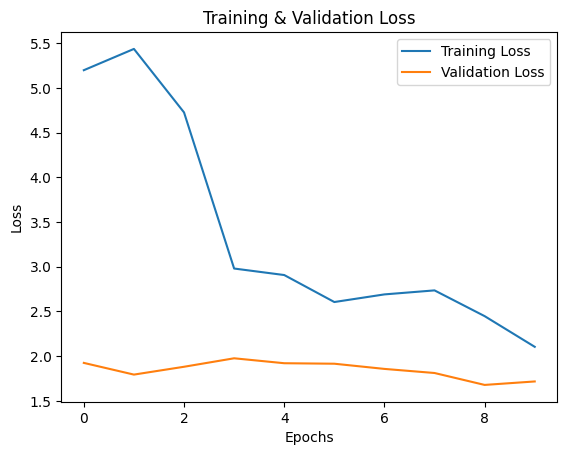

In [9]:
# Plotting training performances
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [10]:
# Save model and tokenizer
output_folder = "bert_docrec"
model_save_path = f"./{output_folder}/model/"
tokenizer_save_path = f"./{output_folder}/tokenizer/"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

('./bert_docrec/tokenizer/tokenizer_config.json',
 './bert_docrec/tokenizer/special_tokens_map.json',
 './bert_docrec/tokenizer/vocab.txt',
 './bert_docrec/tokenizer/added_tokens.json')

In [11]:
# Load the saved model and tokenizer
tokenizer_tuned = BertTokenizer.from_pretrained(tokenizer_save_path)
bert_tuned = DocRecModel.from_pretrained(model_save_path)
bert_tuned.to(device)

DocRecModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

**Define a function to get recommendation from the models**

In [12]:
def get_recommendations(query_doc, all_docs, model, tokenizer, top_k=5):
    # Encode and get embeddings for the query document
    query_encoding = tokenizer(query_doc, truncation=True, padding='max_length', max_length=512, return_tensors="pt").to(device)
    query_embedding = model(query_encoding["input_ids"], query_encoding["attention_mask"]).detach().cpu().numpy()
    query_embedding = query_embedding.reshape(1, -1) # Ensure it's of shape (1, embedding_dimension)

    # Encode and get embeddings for all potential recommendation documents
    all_embeddings = []
    for doc in all_docs:
        doc_encoding = tokenizer(doc, truncation=True, padding='max_length', max_length=512, return_tensors="pt").to(device)
        doc_embedding = model(doc_encoding["input_ids"], doc_encoding["attention_mask"]).detach().cpu().numpy()
        all_embeddings.append(doc_embedding)
    all_embeddings_array = np.vstack(all_embeddings) # Convert list of embeddings to a 2D numpy array

    # Compute cosine similarities
    similarities = cosine_similarity(query_embedding, all_embeddings_array).squeeze()

    # Get indices of top-k documents
    recommended_indices = similarities.argsort()[-top_k:][::-1]

    return [all_docs[i] for i in recommended_indices]

**Recommendations using fine-tuned BERT**

In [13]:
# Example Usage:
query_document = "Under GDPR, how should companies handle user data breaches?"
recommendations = get_recommendations(query_document, documents, bert_tuned, tokenizer_tuned, top_k=5)
for i, rec in enumerate(recommendations):
  print(rec[:64], "...")
  print()

Companies must provide options for users to opt-out of data coll ...

Entities must ensure GDPR compliance when operating within Europ ...

All customer data breaches must be reported to the regulatory au ...

Children’s online data requires additional protective measures a ...

Any sale or transfer of personal data must be transparent and ap ...



**Recommendations using original base BERT**

In [14]:
bert_base = DocRecModel.from_pretrained(model_name)
bert_base.to(device)

recommendations = get_recommendations(query_document, documents, bert_base, tokenizer, top_k=5)
for i, rec in enumerate(recommendations):
  print(rec[:64], "...")
  print()

Privacy policies must be written in clear and understandable lan ...

All customer data breaches must be reported to the regulatory au ...

Children’s online data requires additional protective measures a ...

Regular audits of data storage and processing systems are requir ...

User consent is crucial before collecting or processing any pers ...

